## Question 1


Η μέθοδος loadImages(path) διαβαζει απο το path τις εικονες, τις μετασχηματίζει
σε διασταση 100 * 100 και επιστρεφει δυο πινακες. Ο πρωτος, περιεχει 30 στηλες (μια για καθε εικονα)
με μεγεθος στηλης 30.000 (100 * 100 * 3 , rgb model) ενώ ο δευτερος 30 στηλες με την
ground truth κατηγορια καθε εικονας.

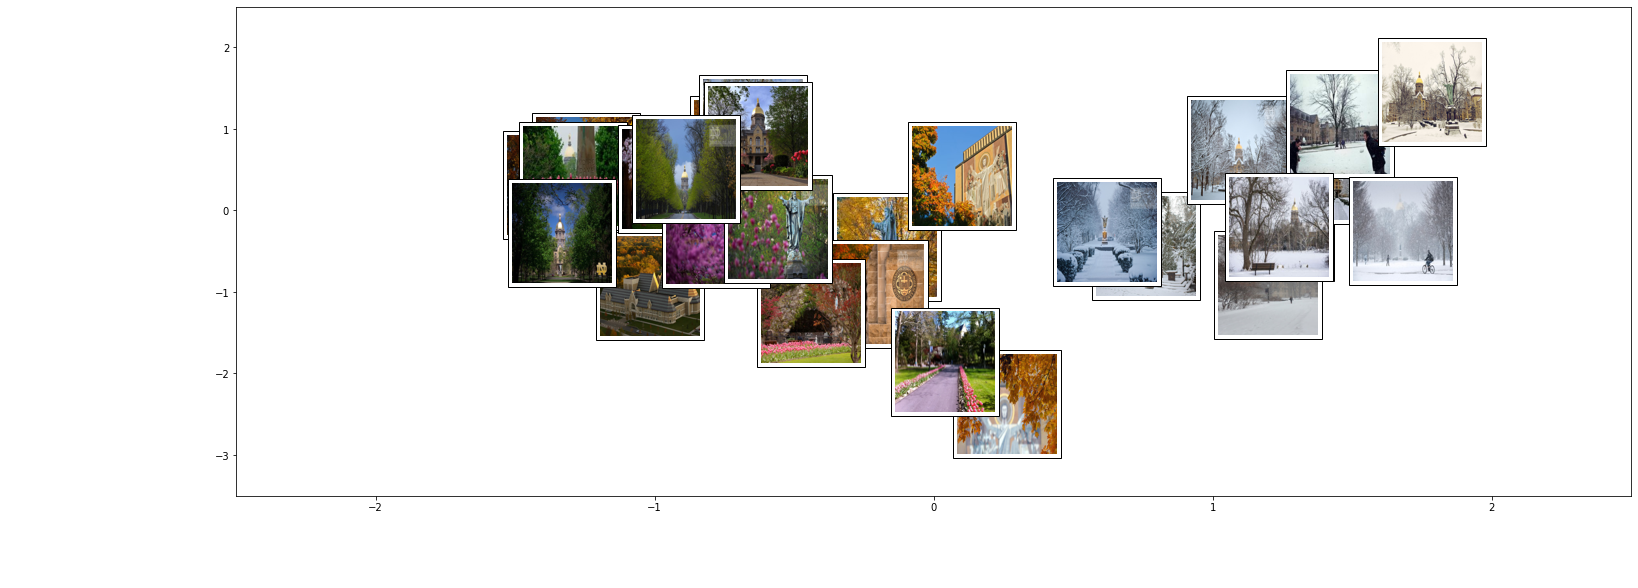

In [90]:
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from sklearn.decomposition import PCA


size_100 = (100,100)
def loadImages(path):
    import numpy as np
    listOfImages = []
    labels = []
    for imageFileName in os.listdir(path):
        image = Image.open(path+"/"+imageFileName)
        image = image.resize(size_100)
        listOfImages.append(np.reshape(image, (100*100*3)))
        if imageFileName.startswith('W'):
            labels.append(0)
        elif imageFileName.startswith('F'):
            labels.append(1)
        else:
            imageFileName.startswith('S')
            labels.append(2)
    return np.asarray(listOfImages).T,np.asarray(labels)

def PCA_ImageSpaceVisualization(X):
    import matplotlib.pyplot as plt
    import numpy as np

    pca = PCA(n_components=2,whiten=True).fit(X)
    components = pca.transform(X)
    projected = pca.inverse_transform(components)

    fig, ax = plt.subplots(figsize=(25,9))
    for n,component in enumerate(components):
        imagebox = OffsetImage(np.reshape(X[n], (100,100,3)).astype(np.uint8))
        imagebox.image.axes = ax
        xy = (component[0],component[1])
        ab = AnnotationBbox(imagebox,xy = xy)
        ax.add_artist(ab)
    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(-3.5,2.5)
    plt.draw()
    plt.show()
    return projected

X, Y = loadImages("images")
X_projected = PCA_ImageSpaceVisualization(X.T)

### 2.1)
Το παραπανω plot απεικονιζει τις πραγματικες εικονες οπως αυτες μεταφερθηκαν στον χωρο δυο διαστασεων. Για τη δημιουργια
του χρησιμοποιηθηκαν τα components του PCA αλλα για την καλυτερη οπτικοποιηση χρησιμοποιηθηκαν οι αρχικες εικονες. Οι
εικονες που βρισκονται κοντα παρουσιαζουν κοινα χαρακτηριστικα ενω όμοια οσες απεχουν παρουσιαζουν αρκετες διαφορες.
Όμοια χαρακτηριστικα μπορουν να εξαχθουν και για τον αρχικο μας χωρο μεγαλων διαστασεων.
### 2.2)
Είναι εμφανες οτι οι χειμωνιατικες εικονες αποτελουν μια ομαδα μιας και διαφερουν εντελως απο τις υπολοιπες. Αντίθετα, οι
εικονες που περιγραφουν ανοιξη και φθινοπωρο βρισκονται πιο κοντα. Αυτο συμβαινει ακριβως επειδη οι διαφορες των χρωματων
μεταξυ των ζευγων χειμωνας - ανοιξη/φθινοπωρο ειναι εντονοτερες ενω οι χρωματικες διαφορες μεταξυ του ζευγους
φθινοπωρο-ανοιξη ειναι πολυ λιγοτερες.

### 3.1)
Η ακριβεια ταξινομησης ειναι μια μετρικη που καθοριζει την αποτελεσματικοτητα των ταξινομητων.
Ορίζεται  ως: $$\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$$ <br>
Για δυαδικη ταξινομηση η αποτελεσματικοτητα οριζεται χρησιμοποιωντας τους ορους θετικων
και αρνητικων προβλεψεων: $$\text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}$$



In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


def classification(X,Y):
    import pandas as pd

    knn = KNeighborsClassifier(1)
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    knn_mean = scores.mean()

    svm_clf = svm.LinearSVC(max_iter=10000,random_state=0, tol=1e-5)
    scores = cross_val_score(svm_clf, X, Y, cv=5, scoring='accuracy')
    svm_mean = scores.mean()
    df = pd.DataFrame([knn_mean,svm_mean], index=["K-NN","Linear SVM"], columns=["CV-Score Mean"])
    return df

df_reduced_size = classification(X_projected,Y)
df_regular_size = classification(X.T,Y)

### 3.2)
##### Classification with Initial Size

In [ ]:
print(df_regular_size)

##### Classification with Reduced Size

In [ ]:
print(df_reduced_size)


### 3.3)

### 3.4)
Για την καλυτερη επιδοση ενος ταξινομητη περαν της επιδοσης του σε ορισμενες περιπτωσεις θα πρεπει να λαβουμε υποψιν και
την ταχυτητα του. Οπως ειναι λογικο σε ορισμενες περιπτωσεις η ταχυτητα ειναι περισσοτερο αποδεκτη αν συνοδευεται απο
μικρη εως ελαχιστη πτωση στην αποδοση. Γενικότερα, θα μπορουσε καποιος να πει οτι πιο "ταιριαστος" θα ειναι ο KNN σε περιπτωση
που εχουμε πολλα δεδομενα σε μικρο χώρο ενώ αντιθετα καλυτερος θα ειναι ο SVM σε χώρο μεγαλων δεδομενων με λιγα σημεια. Σε όσα
πειραματα εκτελεστηκαν παρατηρηθηκε αδυναμια συγκλισης του SVM ακόμη και με αυξημενο αριθμο επαναληψεων. Ο KNN παρουσιαζει
καλυτερη αποδοση στις μειωμενες διαστασεις οπως αναμενοταν απο οσα αναφερθηκαν παραπανω. Σε αυξημενες διαστασεις, όσες φορες συνεκλινε
ο Linear SVM, είχε παρομοια αποδοση με τον KNN.

## Question 2
### Χρήση NMF απο βιβλιοθήκη sklearn
Η βιβλιοθήκη sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) μας παρέχει μια έτοιμη υλοποίηση του αλγορίθμου NMF ο οποίος μπορεί
να προσαρμοστεί στη ζητούμενη μορφή. Πιο συγκριμένα έχουμε:

0.5 * ||X - WH||_Fro^2
<br> + alpha * l1_ratio * ||vec(W)||_ 1
<br> + alpha * l1_ratio * ||vec(H)||_ 1
<br> + 0.5 * alpha * (1 - l1_ratio) * ||W||_ Fro^2
<br> + 0.5 * alpha * (1 - l1_ratio) * ||H||_ Fro^2

Θέτοντας l1_ratio = 0 (default τιμη) έχουμε την κανονικοποιημένη μορφή του NMF. Για την τιμή alpha θέτουμε 0.5 ενώ για
τον αριθμό των συνιστωσών και του σφάλματος χρησιμοποιούμε τις παραμετρικές τιμές k, eps. Τέλος, ο αλγόριθμος έχει ως
default τιμή για υπολογισμό του σφάλματος τη frobenius norm και υπολογίζεται ως εξής:

1. Υπολογισμός αρχικού σφάλματος error_at_init = __beta_divergence(X, W, H, beta_loss, square_root=True) <br>
2. previous_error = error_at_init <br>
3. Υπολογισμός νέου σφάλματος error = _beta_divergence(X, W, H, beta_loss, square_root=True) <br>
4. Έλεγχος αν η διαφορά σφαλμάτων είναι μικρότερη του ζητούμενου <br>
5. Αν ναι τότε τελειώνει η εκτέλεση του αλγορίμου, διαφορετικά previous_error = error και ο αλγόριθμος συνεχίζει. <br>

Τα παραπάνω βήματα έχουν εξαχθεί από τη μέθοδο __fit_multiplicative_update της βιβλιοθήκης προκειμένου να επαληθευτεί
ότι καλύπτει τα ζητούμενα της εκφώνησης. (https://github.com/scikit-learn/scikit-learn/blob/ef5cb84a/sklearn/decomposition/nmf.py#L685)

In [ ]:
import numpy as np
from sklearn.decomposition import NMF
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
def RegNMF(X,k,l,epsilon):
    model = NMF(n_components=k, init='random', random_state=0,tol = epsilon,alpha = l,max_iter = maxIters)
    W = model.fit_transform(X)
    C = model.components_
    return W,C, model.n_iter_

### Χρήση πολλαπλών τιμών μέγιστου αριθμού επαναλήψεων
Παρακάτω παρουσίαζονται 3 εκτελέσεις κάθε μια από τις οποίες έχει
διαφορετικό αριθμό μεγίστων επαναλήψεων. Αρχικά, χρησιμοποιείται
η default τιμή των 200 επ. ενώ στη συνέχεια τρέχουμε το ίδιο
πείραμα για 1000 και 10000 και σχολίαζουμε τη σύγκλιση.

In [ ]:
X = np.absolute(np.random.rand(500,1000))
l = 0.5
ks = [1,10,100]
epsValues = [0.1,0.01,0.001]
plt.figure()
for maxIters in [200,1000,10000]:
    iters = []
    for k in ks:
        row = []
        for epsilon in epsValues:
            W,C, n_iter = RegNMF(X,k,l,epsilon)
            row.append(n_iter)
        iters.append(row)
    df = pd.DataFrame(iters, index=ks, columns=epsValues)
    df
    df = df.cumsum()
    df.plot()
    plt.show()

Τα παραπάνω διαγράμματα αποτελούν οπτικοποιήσεις των πινάκων, όπου στον οριζόντιο άξονα
βρίσκεται η τιμή του k, στον κάθετο άξονα ο αριθμός των επαναλήψεων ενώ κάθε γραμμή
δείχνει την τιμή του ζητούμενου σφάλματος. Από τα διαγράμματα παρατηρούμε: <br>

1. Αναλογία μεταξύ των τιμών k, tol. Όσο αυξάνεται η ακρίβεια του σφάλματος και του αριθμού των συνιστωσών
τόσο περισσότερες επαναλήψεις απαιτεί ο αλγόριθμος. <br>
2. Για σταθερό k παρατηρούμε πως υπάρχει σχεδόν αναλογική αυξηση των επαναλήψεων μεταξύ των διαφορετικών
σφαλμάτων. <br>
3. Ομοίως απο τα διαγράμματα προκύπτει πως με σταθερό σφάλμα η αύξηση των συνιστωσών απαιτεί αύξηση των
επαναλήψεων για να επιτευχθεί σύγκλιση.
